<a href="https://colab.research.google.com/github/david8712403/solar-energy-predict/blob/main/solar_energy_predict(xgboost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIoT 期末報告
## 說明
- dataset\solar_data_202003_202007.csv 為 **新竹市北區海濱路240號** 新竹市環保局掩埋場復育地太陽能案場在 **3月至7月** 其中一個inverter(逆變器)的太陽能發電資料

將資料集(dataset)內的 solar_data_202003_202007.csv 的太陽能案場發電資料做為訓練資料集訓練你的預測模型，用機器學習及深度學習皆可，預測 2020年一月、二月、八月、九月、十月的 **"下一個小時"的發電度數** 。

# 作業
[作業網址: http://aiot.codingmaster.cc:8000](http://aiot.codingmaster.cc:8000)
### 登入帳號為
- 大同大學： ttu + 學號

In [1]:
# 抽卡!!!
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [2]:
# 下載資料集
!gdown --id '1WbbqzP3veoI155D6rPco4sbVVAN8kEJp' --output training_data.csv
!gdown --id '1kjRjzk9mt2JJAiEraUNGo14526ftO537' --output test_data.csv

Downloading...
From: https://drive.google.com/uc?id=1WbbqzP3veoI155D6rPco4sbVVAN8kEJp
To: /content/training_data.csv
3.65MB [00:00, 57.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kjRjzk9mt2JJAiEraUNGo14526ftO537
To: /content/test_data.csv
100% 44.9k/44.9k [00:00<00:00, 73.4MB/s]


In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

import pandas as pd

import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

!pip install matplotlib mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
%matplotlib inline
  
def sameSeed(myseed = 0): # set a random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    print(loss_record['train'])
    print(loss_record['validate'])
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['validate'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['validate'], c='tab:cyan', label='validate')
    # plt.ylim(0.0, max(loss_record['validate']))
    plt.ylim(0.0, 20)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [5]:
import datetime
"""
取得氣象資料
"""
def get_sun_shine_df(start_date, end_date):

  rtn_df = pd.DataFrame()
  # 設定時間區間
  l = pd.date_range(start=start_date,end=end_date)
  for d in l:
    date_str = d.date().strftime("%Y-%m-%d")
    print(f'\r取得{date_str}的天氣資料', end='')

    wether_df = pd.read_html(
        'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?'+
        'command=viewMain&station=467571&stname=%25E6%2596%25B0%25E7%25AB%25B9&datepicker='+
        date_str,
        encoding='utf-8'
    )
    wether_df = wether_df[1]

    temp_sun_df = pd.DataFrame(columns=['GloblRad', 'SunShine', 'Cloud', 'MONTH', 'DAY', 'HOUR'])
    temp_sun_df['GloblRad'] = wether_df['SunShine']['全天空日射量(MJ/㎡)']['GloblRad']
    temp_sun_df['SunShine'] = wether_df['SunShine']['日照時數(hr)']['SunShine']
    temp_sun_df['Cloud'] = wether_df['Cloud']['總雲量(0~10)']['Cloud Amount']
    temp_sun_df = temp_sun_df.replace({'SunShine': '...'}, 0)
    temp_sun_df = temp_sun_df.replace({'Cloud': '...'}, 0)
    temp_sun_df['MONTH'] = d.month
    temp_sun_df['DAY'] = d.day
    temp_sun_df['HOUR'] = wether_df['Unnamed: 0_level_0']['觀測時間(hour)']['ObsTime'] - 1

    rtn_df = rtn_df.append(temp_sun_df, ignore_index=True)

  print(f"\n{start_date}~{end_date}天氣資料")
  print(rtn_df)
  return rtn_df

In [6]:
# 取得test_data的氣象資料（1~2及8~10月）
# 取得1~2月日照資料
test_sun_df = get_sun_shine_df("2020-01-01", "2020-02-29")
# 取得8~10月日照資料並與1~2月合併
test_sun_df_2 = get_sun_shine_df("2020-08-01", "2020-10-31")
test_sun_df = test_sun_df.append(test_sun_df_2, ignore_index=True)

取得2020-02-29的天氣資料
2020-01-01~2020-02-29天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      1    1     0
1          0.0        0     0      1    1     1
2          0.0        0     0      1    1     2
3          0.0        0     0      1    1     3
4          0.0        0   9.0      1    1     4
...        ...      ...   ...    ...  ...   ...
1435       0.0        0   2.0      2   29    19
1436       0.0        0   2.0      2   29    20
1437       0.0        0     0      2   29    21
1438       0.0        0     0      2   29    22
1439       0.0        0     0      2   29    23

[1440 rows x 6 columns]
取得2020-10-31的天氣資料
2020-08-01~2020-10-31天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      8    1     0
1          0.0        0     0      8    1     1
2          0.0        0     0      8    1     2
3          0.0        0     0      8    1     3
4          0.0        0   3.0      8    1     4
...        ...      ...

In [7]:
# 下載test_data，並與氣象資料合併
!gdown --id '1kjRjzk9mt2JJAiEraUNGo14526ftO537' --output test_data.csv
test_df = pd.read_csv('/content/test_data.csv')
test_df = pd.merge(test_df,test_sun_df)
test_df.to_csv('/content/test_data.csv', index=False)
test_df

Downloading...
From: https://drive.google.com/uc?id=1kjRjzk9mt2JJAiEraUNGo14526ftO537
To: /content/test_data.csv
100% 44.9k/44.9k [00:00<00:00, 39.3MB/s]


,NO,MONTH,DAY,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,ACF1,IIT,IHT,DCVL1,DCVL2,IPA,IPB,TOTALKWH,GloblRad,SunShine,Cloud
0,1,1,1,9,5.02,229,226,7.5,7.2,60.2,34,37,775,772,2.48,2.56,37689,0.60,0.0,0
1,2,1,1,12,16.66,231,227,24.6,23.5,60.1,32,33,783,776,8.30,8.38,37711,0.60,0.0,0
2,3,1,1,15,6.97,229,225,10.6,10.1,60.1,35,36,858,780,3.45,3.53,37730,0.60,0.1,0
3,4,1,2,6,0.88,232,227,2.3,2.1,60.1,26,20,765,759,0.41,0.49,37732,0.00,0.0,0
4,5,1,2,9,15.64,231,226,23.0,22.0,60.1,33,36,779,772,7.79,7.87,37755,1.57,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,639,10,30,15,12.84,230,226,19.2,18.2,60.1,38,38,781,776,6.39,6.47,73561,0.96,1.0,0
639,640,10,31,6,2.19,231,228,3.9,3.3,60.1,35,29,746,768,1.07,1.15,73566,0.16,0.6,0
640,641,10,31,9,17.80,234,231,26.4,25.7,60.1,39,42,767,749,8.87,8.95,73597,2.17,1.0,0
641,642,10,31,12,21.62,234,231,31.7,30.8,60.5,43,49,734,713,10.78,10.86,73653,2.40,1.0,0


In [8]:
train_sun_df = get_sun_shine_df("2020-03-01", "2020-07-31")

取得2020-07-31的天氣資料
2020-03-01~2020-07-31天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      3    1     0
1          0.0        0     0      3    1     1
2          0.0        0     0      3    1     2
3          0.0        0     0      3    1     3
4          0.0        0   2.0      3    1     4
...        ...      ...   ...    ...  ...   ...
3667       0.0        0   9.0      7   31    19
3668       0.0        0   8.0      7   31    20
3669       0.0        0     0      7   31    21
3670       0.0        0     0      7   31    22
3671       0.0        0     0      7   31    23

[3672 rows x 6 columns]


In [9]:
df = pd.read_csv('/content/training_data.csv')
df.insert(4, 'timedelta', 0)
df.insert(5, 'kwh', 0)
df['Local_Time'] = df['Local_Time'].str.replace('.000', '')

df['Local_Time'] = pd.to_datetime(df['Local_Time'], format='%Y-%m-%d %H:%M:%S')
df['timedelta'] = (df['Local_Time'].values.astype('int64')  // 10**9) \
                    - (df['Local_Time'].shift(1).values.astype('int64') // 10**9)
df['timedelta'][0] = 0

df['kwh'] = df['OPTPWR'].rolling(2).sum() / 2
df['kwh'] = (df['kwh'] * df['timedelta'] / 3600).round(3)

df2 = pd.DataFrame()
df2 = df[['Local_Time','OPTPWR','timedelta','kwh','ACV1','ACV2','ACCL1','ACCL2','ACF1','IIT','IHT','DCVL1','DCVL2','IPA','IPB','TOTALKWH']]

df2 = df2.groupby(pd.Grouper(key='Local_Time', freq='60Min')).max().reset_index()

df3 = df.groupby(pd.Grouper(key='Local_Time', freq='60Min')).sum().reset_index()
df2['kwh'] = df3['kwh']

df2 = df2.drop(df2[df2['kwh'] <= 0].index)
df2 = df2.drop(columns='timedelta')

df2.insert(1, 'HOUR', 0)
df2.insert(1, 'DAY', 0)
df2.insert(1, 'MONTH', 0)
df2['MONTH'] = pd.DatetimeIndex(df2['Local_Time']).month
df2['DAY'] = pd.DatetimeIndex(df2['Local_Time']).day
df2['HOUR'] = pd.DatetimeIndex(df2['Local_Time']).hour

df2 = df2.drop(columns='Local_Time')

# TODO[Boss]: 加入氣象資料 (https://e-service.cwb.gov.tw/HistoryDataQuery/)
# 合併氣象資料
df2 = pd.merge(df2,train_sun_df)

df2.insert(len(df2.columns)-1, 'kwh', df2.pop('kwh'))

# TODO[Medium]: 我們要預測的是 "下一個" 小時的發電量
# kwh欄位向上位移一小時
df2['kwh'] = df2['kwh'].shift(-1)

# TODO[Medium]: 資料過濾，檢查資料是否正常
df2 = df2[df2['kwh'] < 30]
df2 = df2[df2['ACV1'] > 5]
df2 = df2.drop(df2[(df2['HOUR'] == 18) & (df2['kwh'] >= 10)].index)

df2.to_csv('/content/training_data_processed.csv')

df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTH,DAY,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,ACF1,IIT,IHT,DCVL1,DCVL2,IPA,IPB,TOTALKWH,GloblRad,SunShine,Cloud,kwh
0,3,1,6,1.54,231.0,228.0,3.0,2.7,60.1,31.0,25.0,778.0,771.0,0.78,0.78,43355.0,0.00,0.0,0,3.100
1,3,1,7,4.85,231.0,228.0,7.5,6.8,60.2,37.0,38.0,770.0,780.0,2.42,2.42,43358.0,0.41,0.0,10.0,7.349
2,3,1,8,9.62,233.0,228.0,14.3,13.6,60.1,39.0,42.0,772.0,771.0,4.89,4.89,43365.0,0.55,0.0,10.0,7.851
3,3,1,9,15.28,232.0,228.0,22.3,21.6,60.1,41.0,36.0,780.0,770.0,6.77,8.10,43373.0,0.50,0.0,0,3.695
4,3,1,10,7.55,231.0,227.0,11.4,10.6,60.1,41.0,46.0,778.0,760.0,3.76,3.77,43376.0,0.76,0.0,10.0,7.912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,7,31,13,21.90,229.0,225.0,33.0,32.1,60.4,57.0,62.0,695.0,672.0,11.18,11.13,62055.0,3.01,1.0,4.0,19.139
1753,7,31,14,20.80,230.0,228.0,30.4,29.7,60.3,55.0,59.0,710.0,694.0,10.57,10.48,62074.0,2.63,1.0,0,14.100
1754,7,31,15,18.20,231.0,228.0,27.0,25.9,60.1,52.0,53.0,724.0,719.0,9.19,9.16,62088.0,1.74,1.0,0,8.439
1755,7,31,16,13.75,230.0,228.0,20.3,19.7,60.1,51.0,48.0,705.0,720.0,6.79,7.01,62097.0,1.03,0.8,4.0,4.947


In [10]:
df = pd.read_csv('/content/training_data_processed.csv')
df_pred = pd.read_csv('/content/test_data.csv')
x_pred = df_pred[['HOUR', 'OPTPWR', 'ACV1', 'ACV2', 'ACCL1','ACCL2', 'IIT', 'IHT', 'IPA', 'IPB', 'GloblRad']]
x = df[['HOUR', 'OPTPWR', 'ACV1', 'ACV2', 'ACCL1','ACCL2', 'IIT', 'IHT', 'IPA', 'IPB', 'GloblRad']]
y = df[['kwh']]

print(x)
print(y)
print(x_pred)

      HOUR  OPTPWR   ACV1   ACV2  ACCL1  ...   IIT   IHT    IPA    IPB  GloblRad
0        6    1.54  231.0  228.0    3.0  ...  31.0  25.0   0.78   0.78      0.00
1        7    4.85  231.0  228.0    7.5  ...  37.0  38.0   2.42   2.42      0.41
2        8    9.62  233.0  228.0   14.3  ...  39.0  42.0   4.89   4.89      0.55
3        9   15.28  232.0  228.0   22.3  ...  41.0  36.0   6.77   8.10      0.50
4       10    7.55  231.0  227.0   11.4  ...  41.0  46.0   3.76   3.77      0.76
...    ...     ...    ...    ...    ...  ...   ...   ...    ...    ...       ...
1727    13   21.90  229.0  225.0   33.0  ...  57.0  62.0  11.18  11.13      3.01
1728    14   20.80  230.0  228.0   30.4  ...  55.0  59.0  10.57  10.48      2.63
1729    15   18.20  231.0  228.0   27.0  ...  52.0  53.0   9.19   9.16      1.74
1730    16   13.75  230.0  228.0   20.3  ...  51.0  48.0   6.79   7.01      1.03
1731    17    7.20  230.0  228.0   11.0  ...  50.0  47.0   3.24   3.97      0.49

[1732 rows x 11 columns]
  

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_train

,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,IIT,IHT,IPA,IPB,GloblRad
601,11,24.05,234.0,228.0,35.7,34.5,46.0,52.0,12.25,12.13,3.58
882,16,11.52,231.0,227.0,17.1,16.3,46.0,42.0,5.60,5.95,0.95
1220,6,5.90,230.0,225.0,9.0,8.4,43.0,45.0,2.97,2.97,0.31
598,8,15.42,231.0,226.0,23.1,22.2,44.0,39.0,7.97,7.66,1.91
664,9,9.29,231.0,226.0,14.1,13.2,42.0,49.0,4.64,4.62,0.59
...,...,...,...,...,...,...,...,...,...,...,...
1558,12,23.22,229.0,226.0,34.5,33.8,56.0,62.0,11.75,11.87,3.53
1608,6,3.79,230.0,227.0,6.0,5.3,50.0,47.0,1.92,1.89,0.48
493,14,10.90,230.0,226.0,16.5,15.6,39.0,35.0,5.49,5.47,0.82
527,6,2.43,230.0,227.0,4.1,3.6,35.0,31.0,1.21,1.23,0.06


In [24]:
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error as MSE

params = {
  'booster': 'gbtree',
  'objective': 'reg:gamma',
  'gamma': 0.25,
  'max_depth': 3,
  'lambda': 5,
  'subsample': 0.8,
  'colsample_bytree': 0.7,
  'min_child_weight': 15,
  'silent': 0,
  'eta': 0.15,
  'seed': 1000,
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test,y_test)
num_rounds = 500
plst = params.items()
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
#                     num_boost_round=500,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

pred = model.predict(dtest)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

[0]	Test-gamma-nloglik:14.3396
Will train until Test-gamma-nloglik hasn't improved in 10 rounds.
[1]	Test-gamma-nloglik:12.5195
[2]	Test-gamma-nloglik:10.9668
[3]	Test-gamma-nloglik:9.62538
[4]	Test-gamma-nloglik:8.48381
[5]	Test-gamma-nloglik:7.52909
[6]	Test-gamma-nloglik:6.70581
[7]	Test-gamma-nloglik:6.01354
[8]	Test-gamma-nloglik:5.43586
[9]	Test-gamma-nloglik:4.94681
[10]	Test-gamma-nloglik:4.52869
[11]	Test-gamma-nloglik:4.18432
[12]	Test-gamma-nloglik:3.88967
[13]	Test-gamma-nloglik:3.64514
[14]	Test-gamma-nloglik:3.44821
[15]	Test-gamma-nloglik:3.27793
[16]	Test-gamma-nloglik:3.1368
[17]	Test-gamma-nloglik:3.0263
[18]	Test-gamma-nloglik:2.93312
[19]	Test-gamma-nloglik:2.85772
[20]	Test-gamma-nloglik:2.79171
[21]	Test-gamma-nloglik:2.74409
[22]	Test-gamma-nloglik:2.70478
[23]	Test-gamma-nloglik:2.66897
[24]	Test-gamma-nloglik:2.64392
[25]	Test-gamma-nloglik:2.62334
[26]	Test-gamma-nloglik:2.60811
[27]	Test-gamma-nloglik:2.59127
[28]	Test-gamma-nloglik:2.57858
[29]	Test-gamma-nl

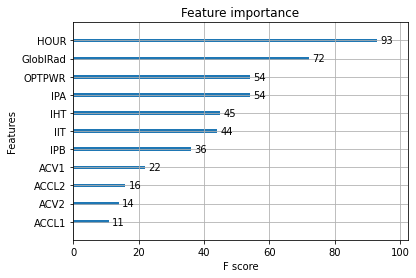

In [25]:
# 顯示重要特徵
plot_importance(model)
plt.show()

In [26]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'predict_kwh'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])

# 對測試集進行預測
dtest = xgb.DMatrix(x_pred)
ans = model.predict(dtest)

preds = ans
save_pred(preds, 'pred.csv')   

Saving results to pred.csv


# 作業繳交
- 將作業 .csv檔案 上傳即可看到分數

## 期末分數
### 實作(70%)
- 取最低的 MSE
- Simple Baseline: 60~69分
- Medium Baseline: 70~79分
- Strong Baseline: 80~89分
- Boss Baseline: 90~100分

### 報告(30%)
- 每組 1-3 人
- 每組報告 5 - 10 分鐘
- 報告 Outlines
    - 組員及分工
    - 資料處理方式
    - 使用的訓練模型 (成功做出兩個或以上模型會加分，有機器學習與深度學習的比較更佳)
    - 最高分數 與 分析模型優點 (or 多個模型間的互相比較)
    - 過程中遇到的困難及如何解決 or 心得 or 這學期上課的收穫
    - 課程建議 (如果沒有建議可以不用)

### 報告順序
將在 5/19(三) 上課時抽出

# 注意事項及規則
- 每組一天只能上傳五次，請勿用任何方式上傳超過五次
- 伺服器又貴又脆弱，請不要攻擊它QQ
- 請不要把你的預測資料給其他同學上傳
- 請不要分享你的 CODE 給其他同學或是其他生物
- 請勿使用你用其他管道拿到其它天的發電資料，或是在網路上找到的其他發電資料
- 請勿使用任何別人已經訓練過的 pre-train model
- 伺服器會記錄你每次上傳的答案，所以很容易抓到你上傳其他同學的資料
- 違反以上任何規則，以作弊論，期末作業直接0分，不得異議